# Single Cell Sequencing
## Cluster only tomato cells 

In [16]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
import anndata as ad
import hdf5plugin
from sklearn.decomposition import TruncatedSVD
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
import os 
#external modules
#pretty plotting
import seaborn as sb
import sys 
import config as general_paths
import warnings
warnings.filterwarnings("ignore")
sb.set_context(context='poster')

import copy

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80)

scanpy==1.9.8 anndata==0.9.2 umap==0.5.5 numpy==1.24.4 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.1.3 statsmodels==0.14.1 igraph==0.10.8 louvain==0.8.1 pynndescent==0.5.11


In [17]:
figure_path = general_paths.figures_path
data_path = general_paths.data_path
output_path = general_paths.output_path
local_path = general_paths.local_path
input_path = output_path

## Data loading

In [33]:
adata_path = os.path.join(input_path,'campari_from_kallisto.h5ad')
adata_all_path = os.path.join(input_path,'campari_raw_all_genes_from_kallisto.h5ad')

campari_umap_file = 'campari_umap_from_kallisto.h5ad'

matlab_matrix_file_name =  'tomato_cells_only_from_kallisto'


NO_PCA = 20 
HOW_MANY_HIGHLY_VARIABLE_GENES = 16000

In [34]:
adata = ad.read_h5ad(adata_path)
adata_all = ad.read_h5ad(adata_all_path)

In [35]:
adata

AnnData object with n_obs × n_vars = 2126 × 16000
    obs: 'sample', 'stimulus', 'red', 'green', 'well_id', 'plate_number', 'batch', 'stimulus_name', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes'
    var: 'gene_id', 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'sample_colors', 'stimulus_name_colors'

In [36]:
# Select only the cells where stimulus was 20 (TRPM8 +td tomato)
adata_tomato = adata[adata.obs['stimulus'] == 20]
adata_all_tomato = adata_all[adata_all.obs['stimulus'] == 20]

In [37]:
adata_tomato

View of AnnData object with n_obs × n_vars = 79 × 16000
    obs: 'sample', 'stimulus', 'red', 'green', 'well_id', 'plate_number', 'batch', 'stimulus_name', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes'
    var: 'gene_id', 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'sample_colors', 'stimulus_name_colors'

In [38]:
list_of_hvg2keep = adata_tomato.var.highly_variable.index

In [39]:
adata_tomato.var.highly_variable # pandas series indexes are gene names, values are bool True

gene_name
Gm29155                 True
C730036E19Rik           True
Gm29157                 True
Pcmtd1                  True
Cdh7                    True
                        ... 
Uty                     True
Ddx3y                   True
ENSMUSG00000096808.2    True
ENSMUSG00000095041.8    True
ENSMUSG00000095742.2    True
Name: highly_variable, Length: 16000, dtype: bool

In [40]:
adata_tomato.raw.X

<79x21764 sparse matrix of type '<class 'numpy.float64'>'
	with 584690 stored elements in Compressed Sparse Row format>

In [41]:
# go back to raw data
adata_tomato = adata_tomato.raw.to_adata() # (it is already nromalized and log transformed)

In [42]:
# save all normalized and log transformed in raw slot.
adata_tomato.raw = adata_tomato

In [43]:
# make names unique
adata_tomato.var_names_make_unique()

In [44]:
# because sc get_highly_variable_genes did not work on raw data
# try the workaround where I manually select previously selected hvg
genes_as_indexes = []
indexes_of_hvg2keep = []
for i in range(len(adata_tomato.var['gene_name'])):
    if adata_tomato.var['gene_name'][i] in list_of_hvg2keep:
        if adata_tomato.var['gene_name'][i] not in genes_as_indexes:
            indexes_of_hvg2keep.append(i)
            genes_as_indexes.append(adata_tomato.var['gene_name'][i])
print(len(indexes_of_hvg2keep)) # why 16004 indexes while there are 16000 hv genes?
# if removing duplicate names, there are 15995 gene left???

15995


In [45]:
# keep hvg that were selected previously for all cells
adata_tomato = adata_tomato[:, indexes_of_hvg2keep]
# pca requires "higly variable genes" to work so add that structure with True booleans for all genes
# Create a pandas Series with True values
highly_variable = pd.Series([True] * len(genes_as_indexes), index=genes_as_indexes)
highly_variable = highly_variable.rename_axis('gene_name')
highly_variable.name = 'highly_variable'

# Step 3: Assign the Series to the .var attribute of the AnnData object
adata_tomato.var['highly_variable'] = highly_variable


In [46]:
adata_tomato

AnnData object with n_obs × n_vars = 79 × 15995
    obs: 'sample', 'stimulus', 'red', 'green', 'well_id', 'plate_number', 'batch', 'stimulus_name', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes'
    var: 'gene_id', 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable'
    uns: 'hvg', 'log1p', 'sample_colors', 'stimulus_name_colors'

In [47]:
adata_tomato.var.highly_variable

gene_name
Gm29155                 True
C730036E19Rik           True
Gm29157                 True
Pcmtd1                  True
Cdh7                    True
                        ... 
Uty                     True
Ddx3y                   True
ENSMUSG00000096808.2    True
ENSMUSG00000095041.8    True
ENSMUSG00000095742.2    True
Name: highly_variable, Length: 15995, dtype: bool

In [48]:
sc.pp.regress_out(adata_tomato, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata_tomato, max_value=10)

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:09)


## Principal Component Analysis

In [49]:
# Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.
sc.tl.pca(adata_tomato, use_highly_variable=True, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


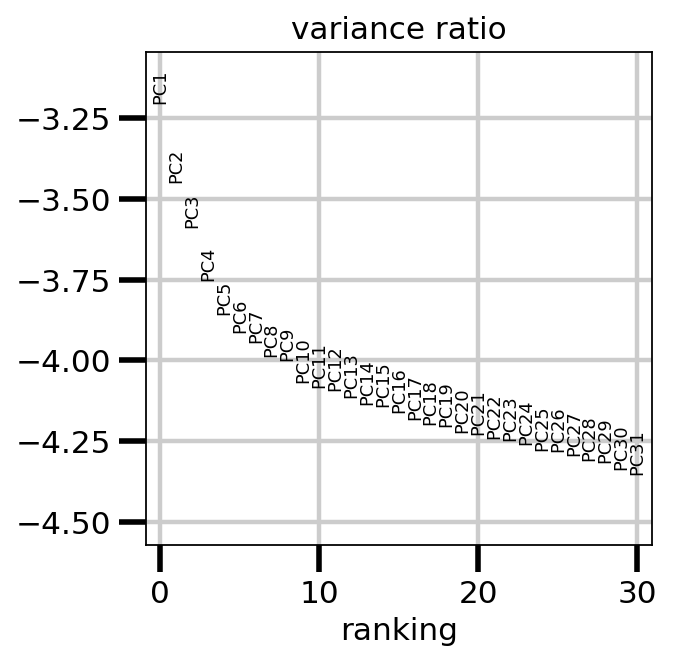

In [50]:
# Let us inspect the contribution of single PCs to the total variance in the data. 
# This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function
sc.pl.pca_variance_ratio(adata_tomato, log=True)

# Computing the neighborhood graph

In [51]:
# Let us compute the neighborhood graph of cells using the PCA representation of the data matrix
sc.pp.neighbors(adata_tomato, n_pcs=NO_PCA)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


# Embedding the neighborhood graph

In [52]:
# We suggest embedding the graph in two dimensions using UMAP 
sc.tl.umap(adata_tomato)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


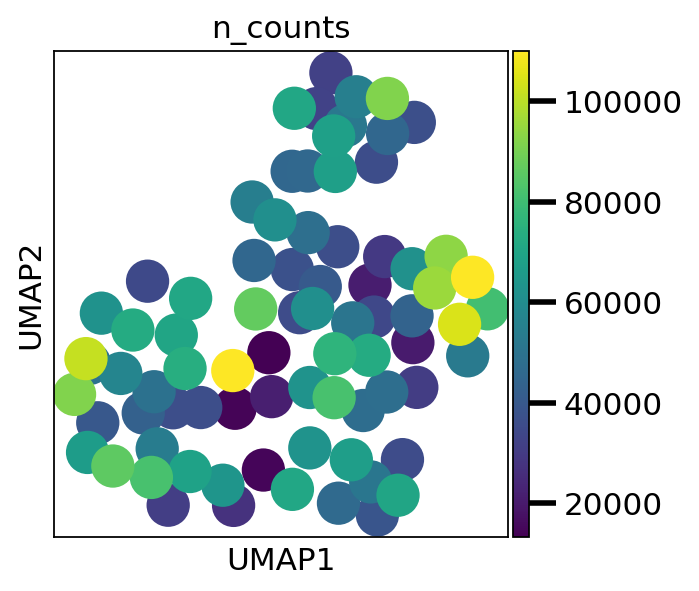

In [53]:
# You can also plot the scaled and corrected gene expression by explicitly stating that you don’t want to use .raw
sc.pl.umap(adata_tomato, color='n_counts', use_raw=False)

# Clustering the neighborhood graph

In [54]:
# Perform clustering - using highly variable genes
louvain_paramenters = [0.5,1,1.5,2,2.5]
louvain_names = []
for value in louvain_paramenters:
    louvain_names.append('louvain_r' + str(value))

for value,name in zip(louvain_paramenters,louvain_names):
    sc.tl.louvain(adata_tomato, resolution=value, key_added=name)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 2 clusters and added
    'louvain_r0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 4 clusters and added
    'louvain_r1', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 7 clusters and added
    'louvain_r1.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'louvain_r2', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 17 clusters and added
    'louvain_r2.5', the cluster labels (adata.obs, categorical) (0:00:00)


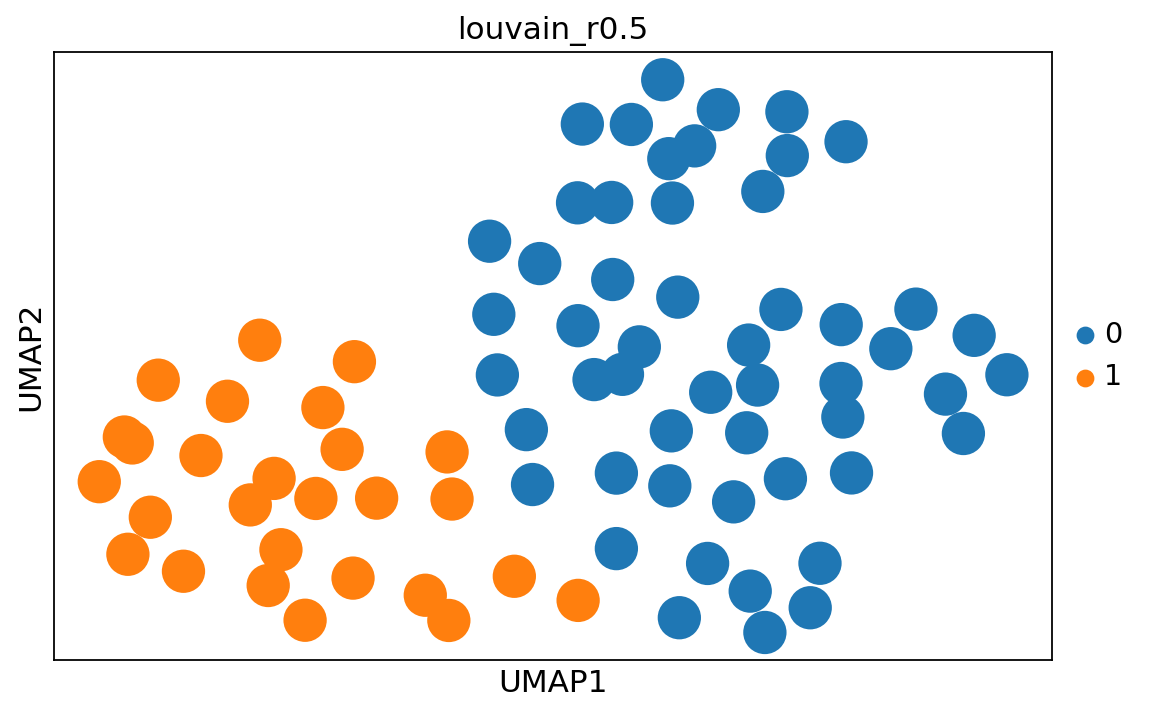

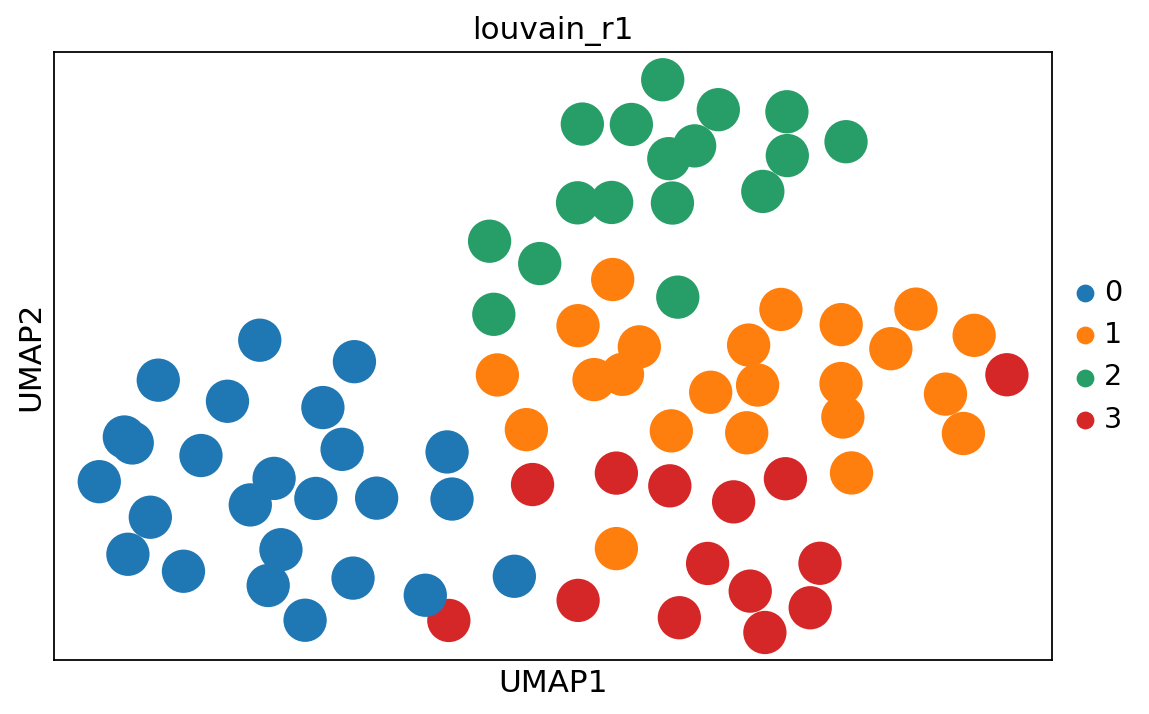

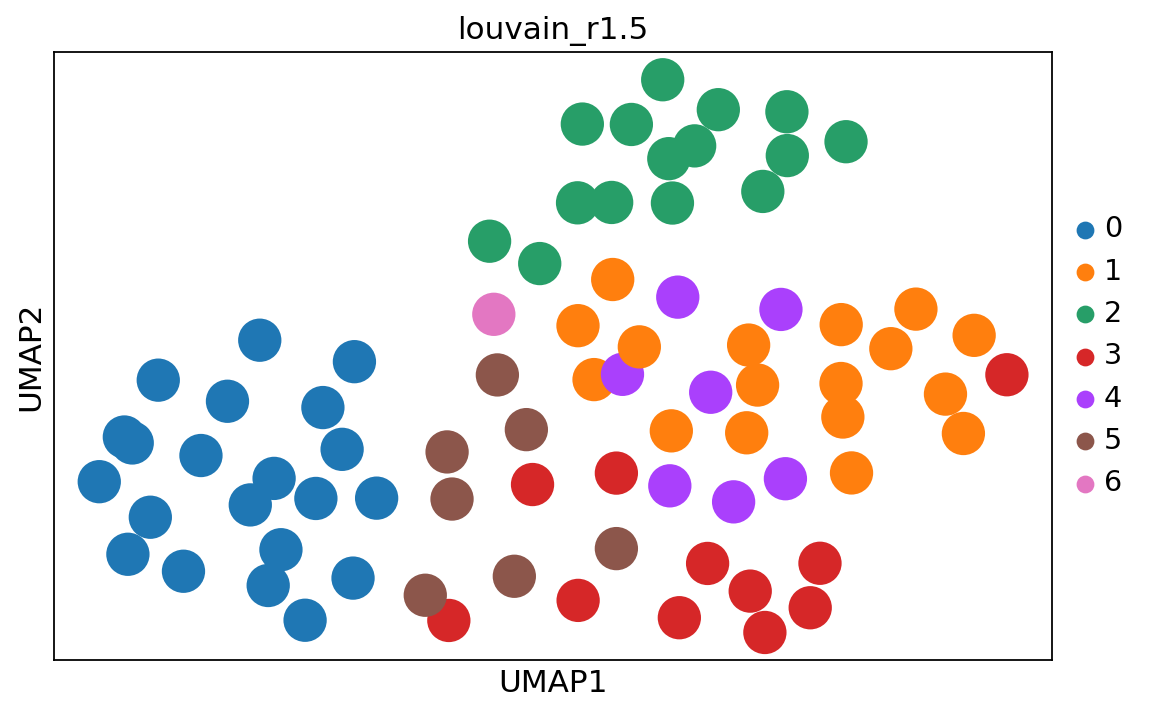

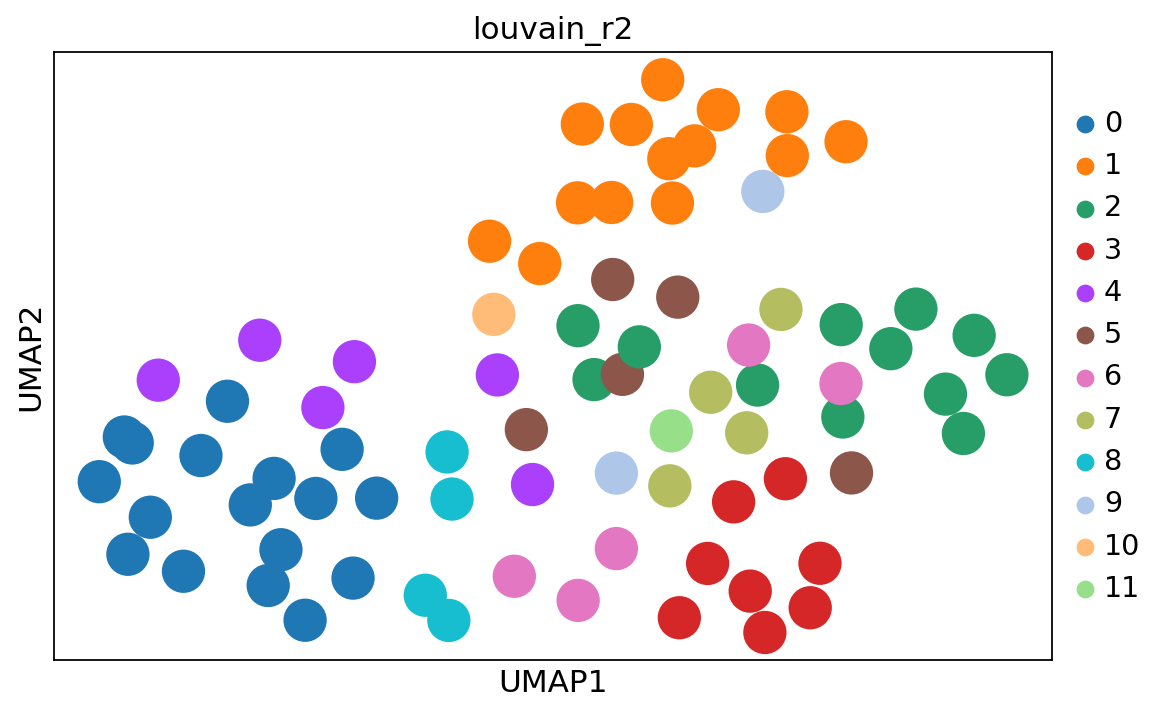

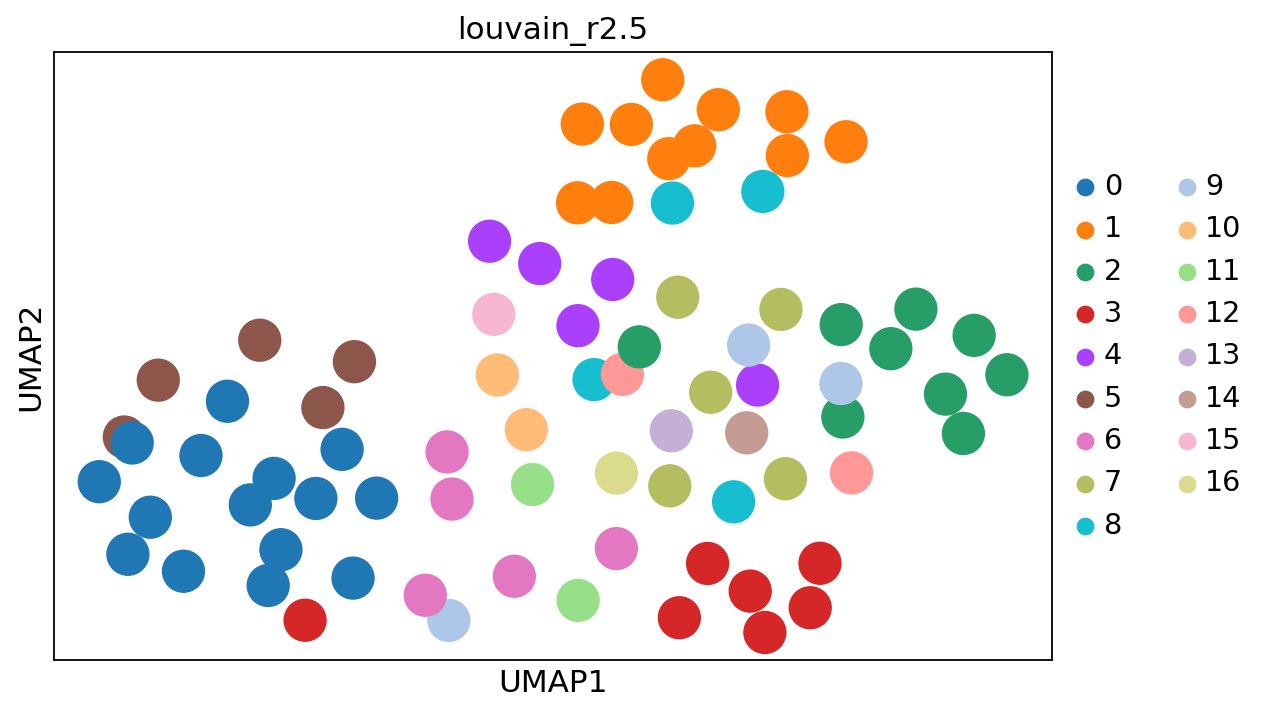

In [55]:
rcParams['figure.figsize']=(8,5)

# Visualize the clustering and how this is reflected by different technical covariates
for name in louvain_names:
    sc.pl.umap(adata_tomato, color=[name], use_raw=False)

In [56]:
adata_tomato.var_names_make_unique()

In [57]:
#################################################################################
#################################################################################
#################################################################################
#################### HERE WE EXPORT ALL THE INFORMATION AS .MAT ################

### we export sparse data matrix, stimuli and flourecence information, umap transformation information and
### louvain transformation

### create and exportable varable list of genes names
gene_name = []
for i in range(len(adata_tomato.var['gene_name'])):
    gene_name.append(adata_tomato.var['gene_name'].iloc[i])
    
gene_name_all = []
for i in range(len(adata_all_tomato.var['gene_name'])):
    gene_name_all.append(adata_all_tomato.var['gene_name'].iloc[i])
### transform adata sparse matrix to scipy
x_all = adata_all_tomato.X
x = adata_tomato.X
### create exportable arrays with information about stimuli, fluorecence, and louvain transformations
stim = np.zeros((x.shape[0],))
red = np.zeros((x.shape[0],))
green = np.zeros((x.shape[0],))
louvain = np.zeros((x.shape[0],len(louvain_names)))
for i in range(x.shape[0]):
    stim[i] = adata_tomato.obs['stimulus'][i]
    red[i] = adata_tomato.obs['red'][i]
    green[i] = adata_tomato.obs['green'][i]
    count = 0
    for name in louvain_names:
        louvain[i,count] = adata_tomato.obs[name][i]
        count = count + 1
data = {'umap': adata_tomato.obsm['X_umap'],'gene_name' : np.array(gene_name_all),'gene_name_matrix' : np.array(gene_name),'sparse_matrix': x_all,'matrix': x,'stimuli':stim,
        'red_intesity': red, 'green_intensity': green, 'louvain' : louvain, 'louvain_name': louvain_names}

from time import strftime
from datetime import datetime
today = datetime.now().strftime("%Y_%m_%d")
scipy.io.savemat(os.path.join(input_path , matlab_matrix_file_name+"_"+str(today)+'.mat'), data)

#################################################################################
#################################################################################
#################################################################################

In [58]:
# list of genes of interest to Marcin
genes4df = ['Calca', 'Scn10a', 'Nefh', 'Piezo2', 'Bmpr1b', 'Kit', 'Trpm8', 'Trpv1', 
            'Sstr2', 'S100b', 'Adra2a', 'Chrna7', 'Adm', 'Smr2', 'Krt79','Ntrk1','Ntrk2','Ntrk3','Ret','Tac1']

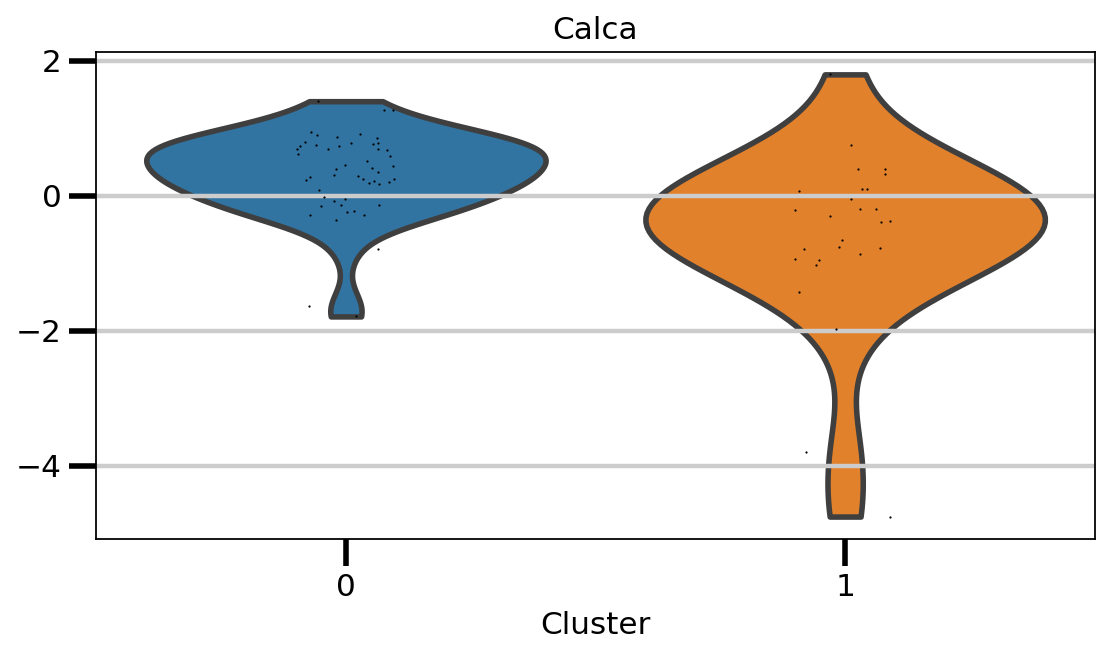

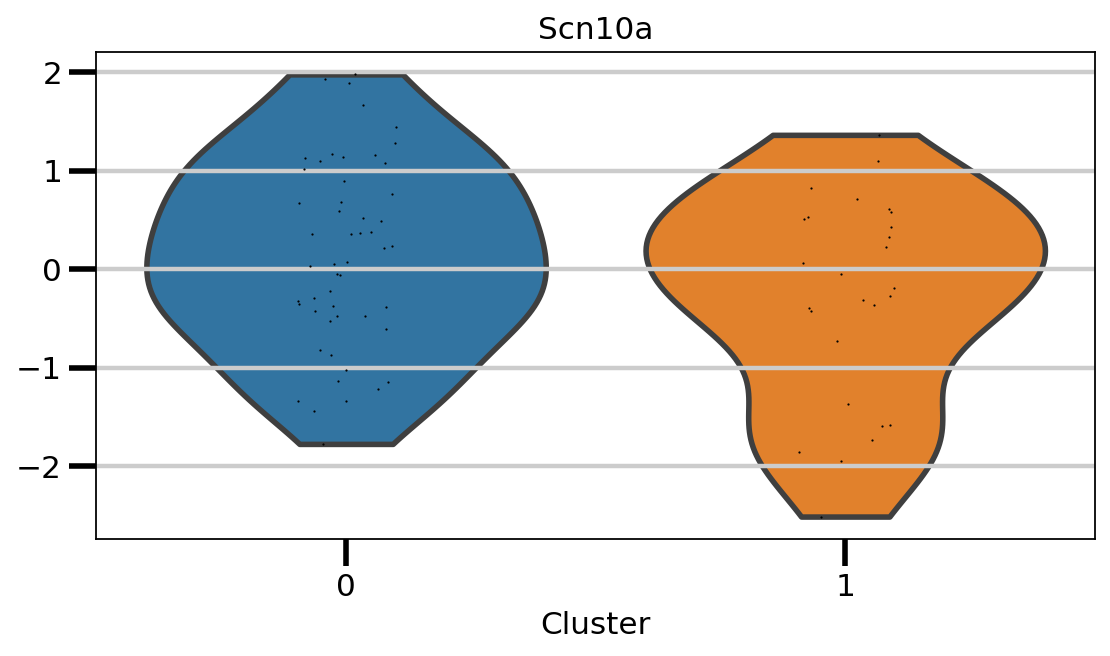

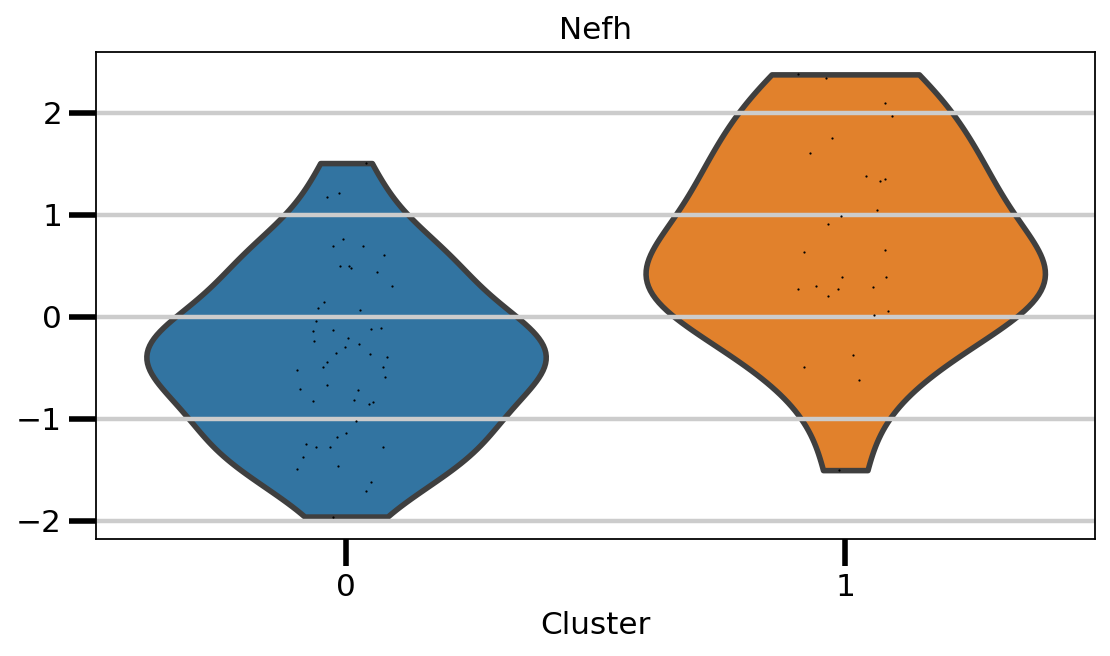

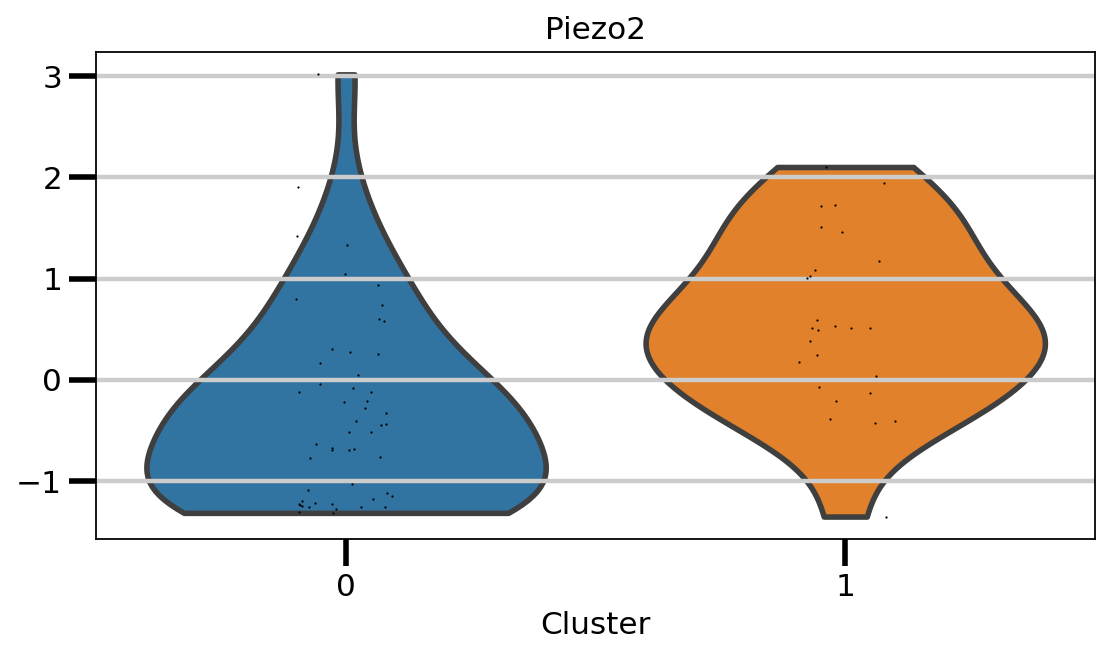

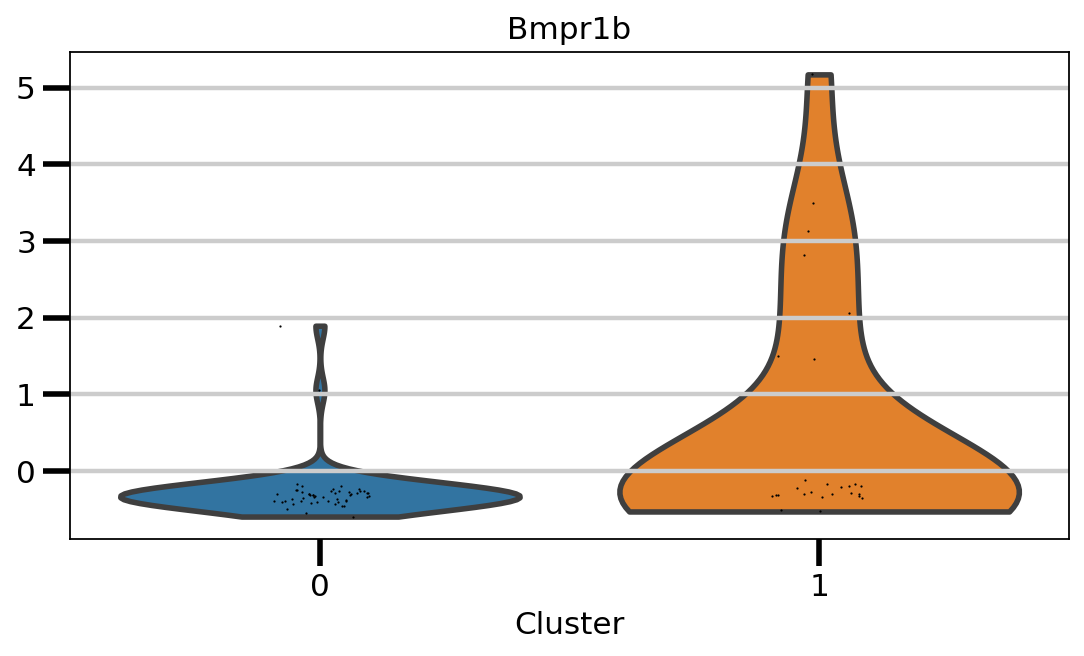

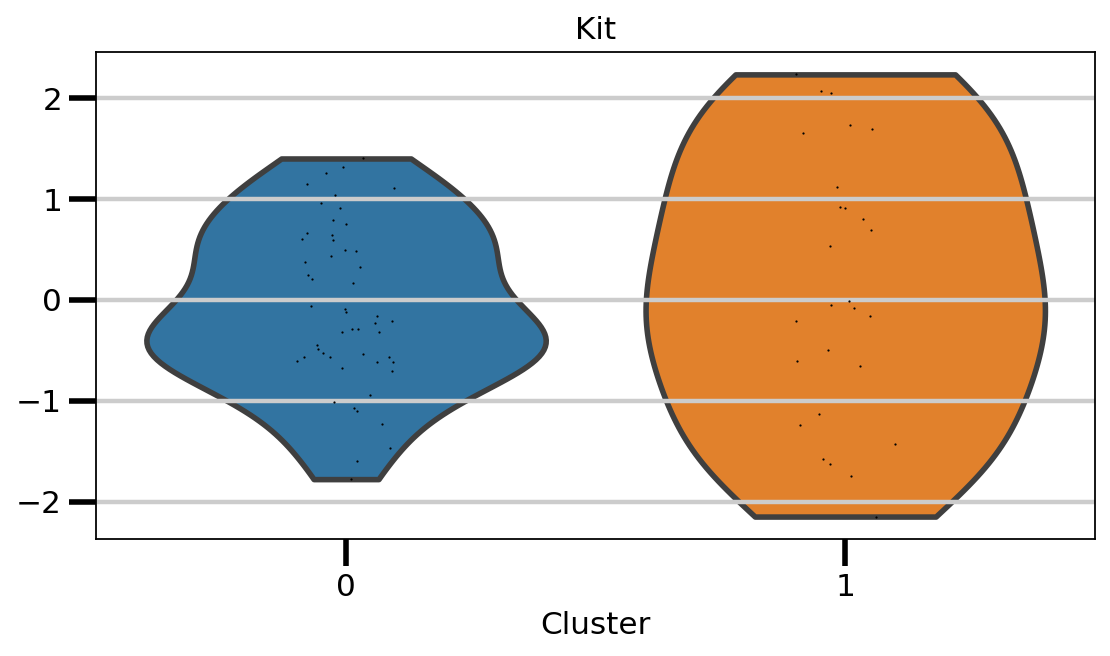

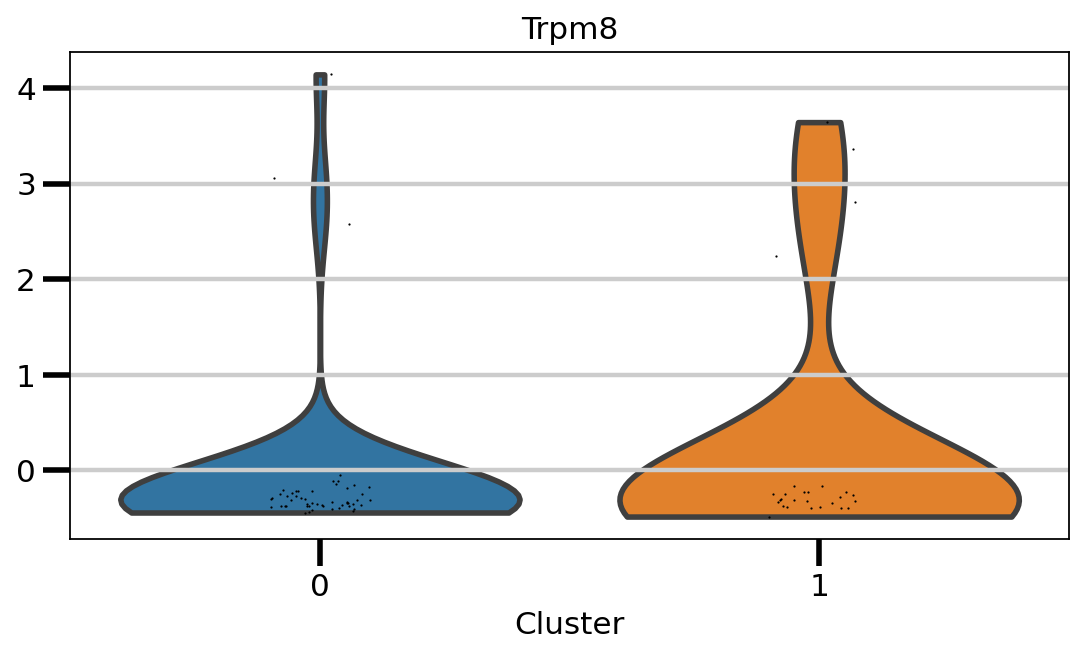

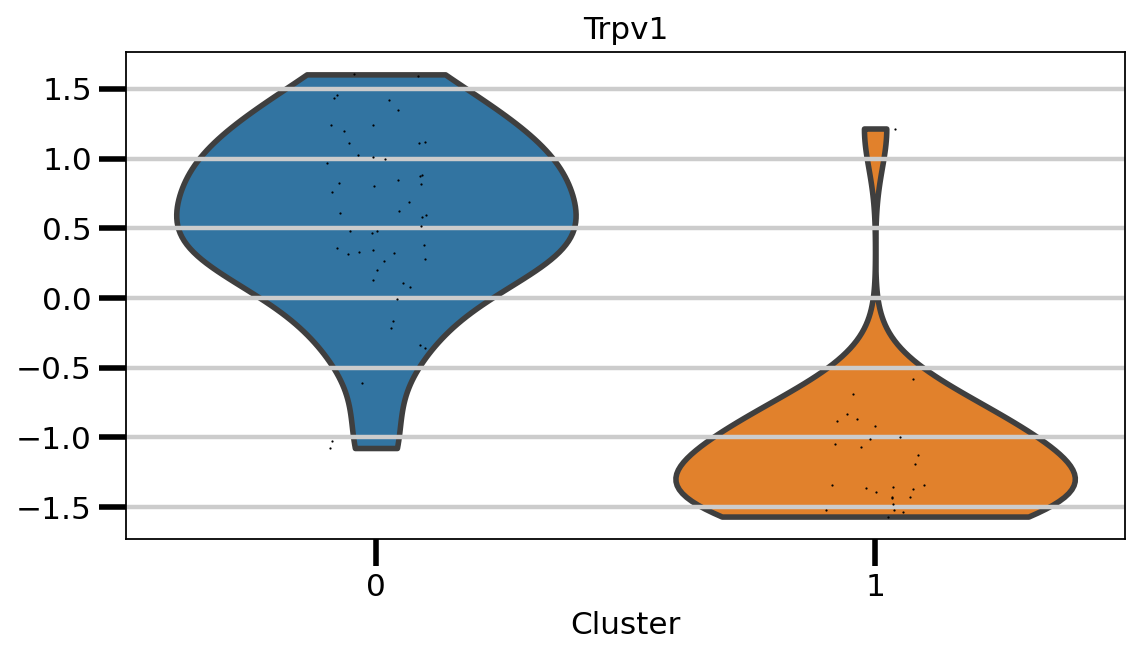

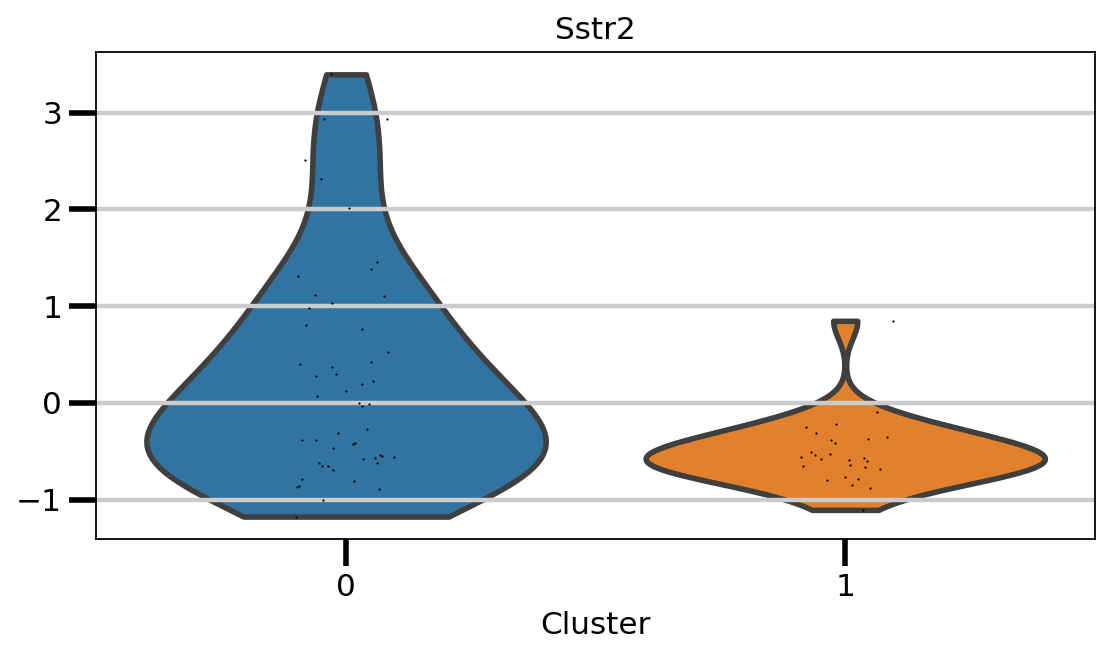

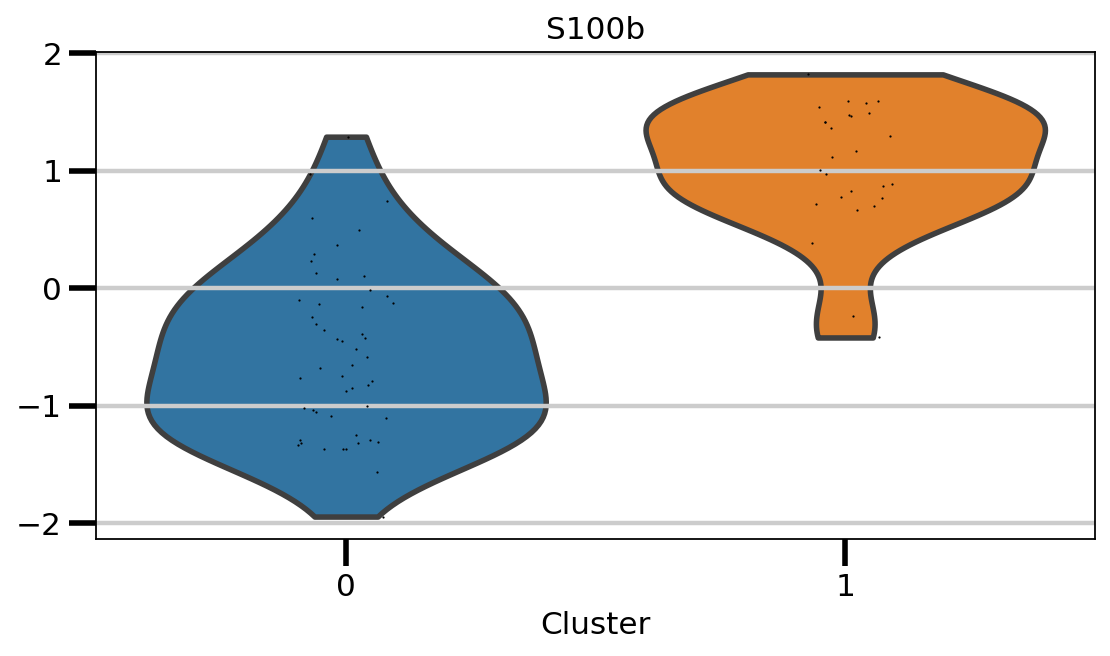

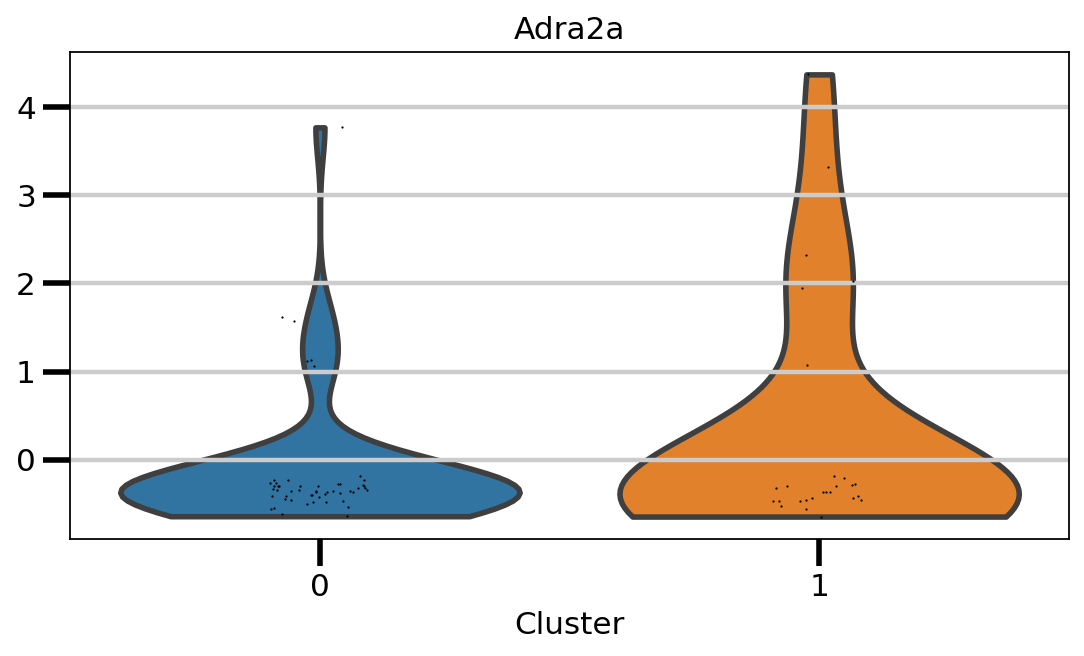

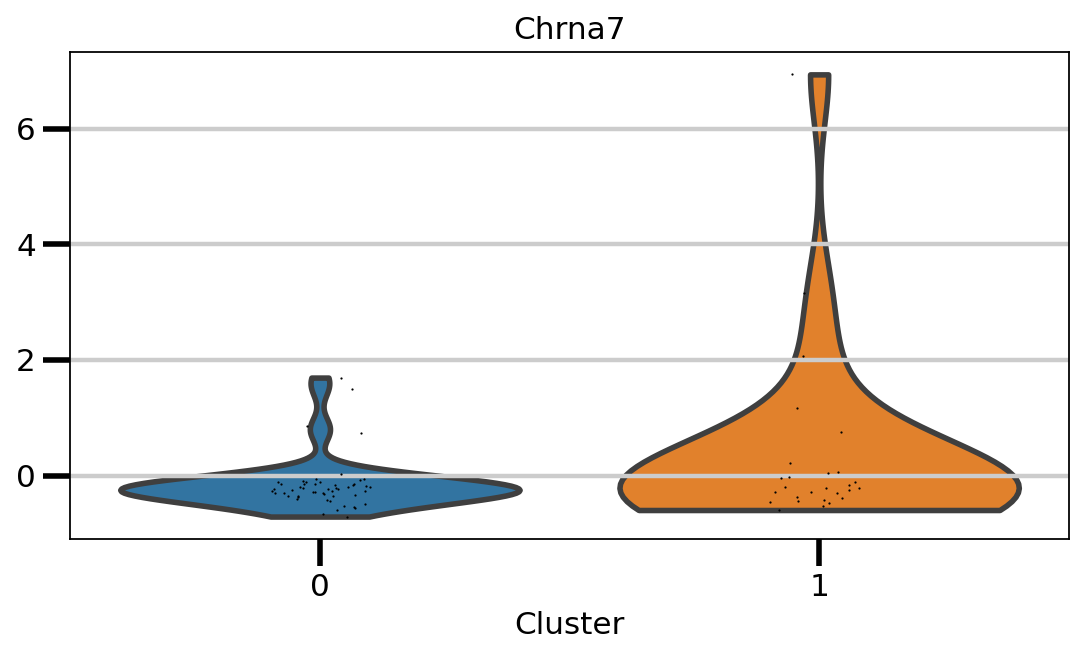

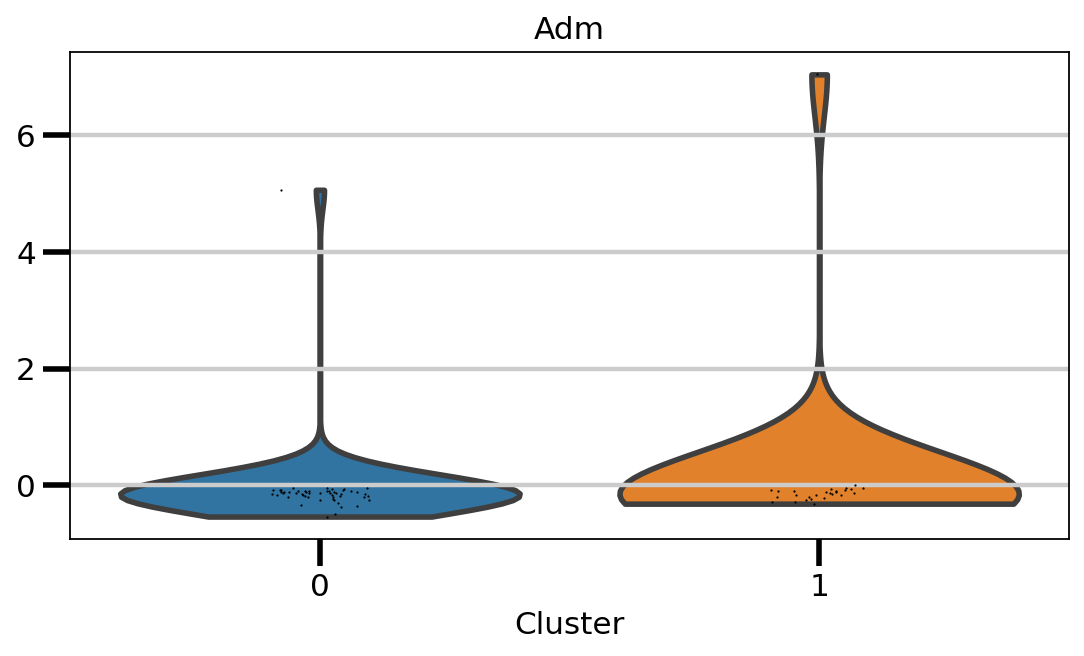

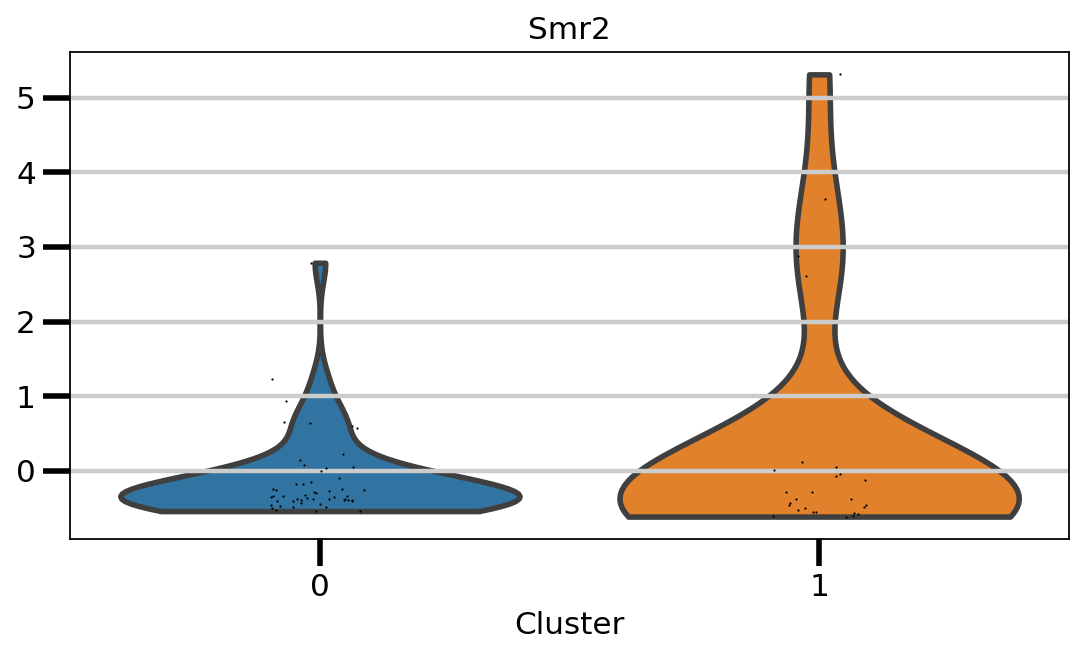

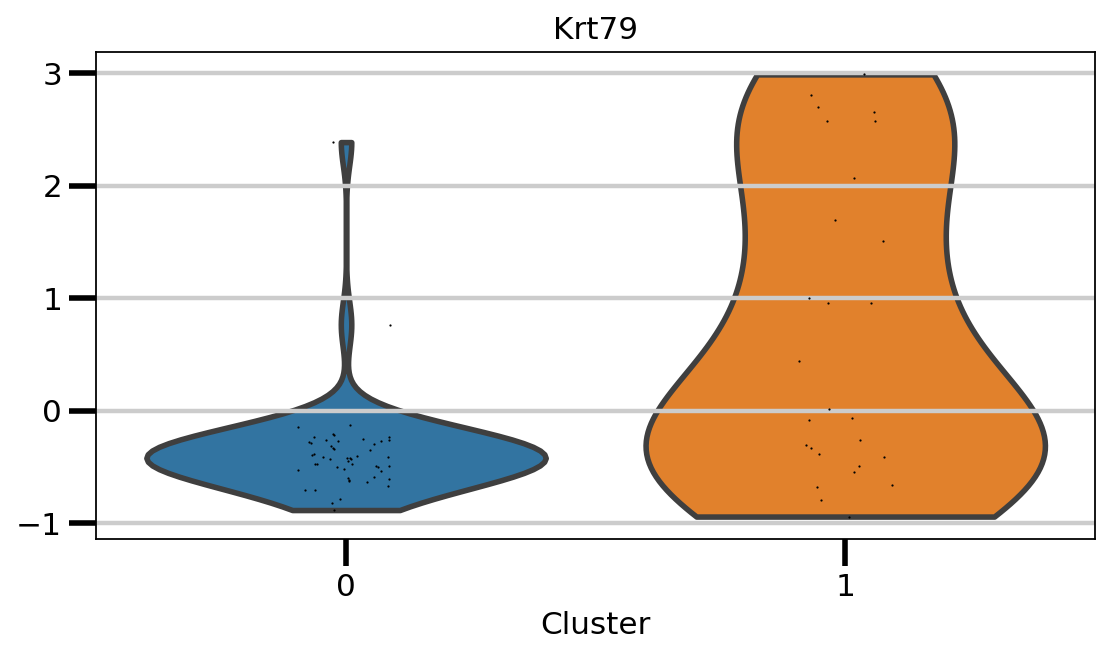

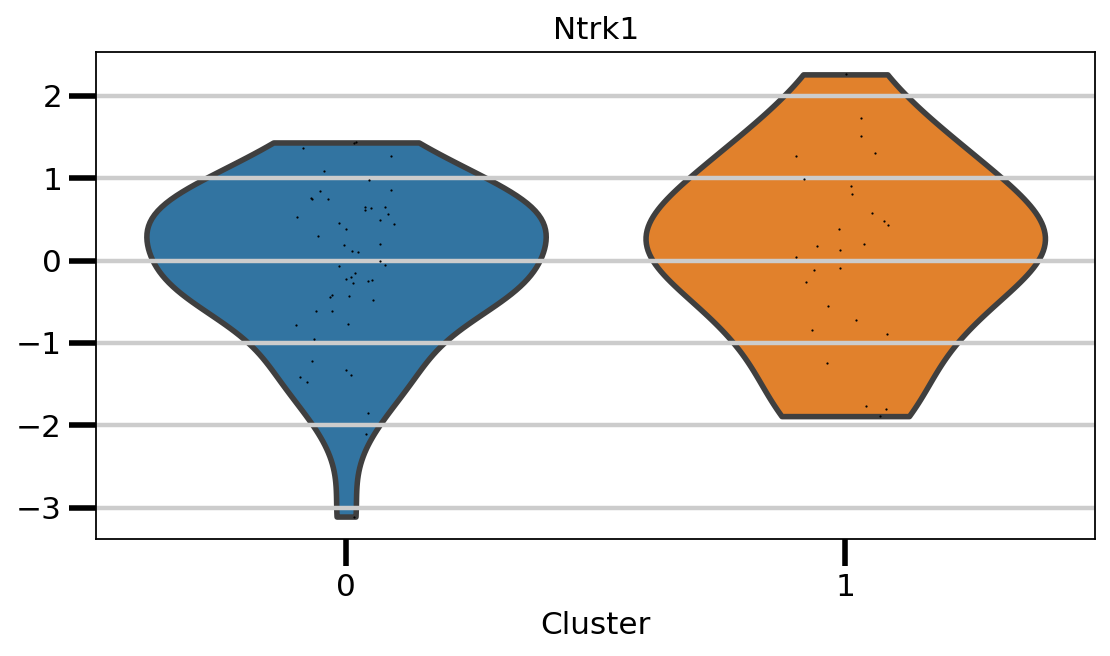

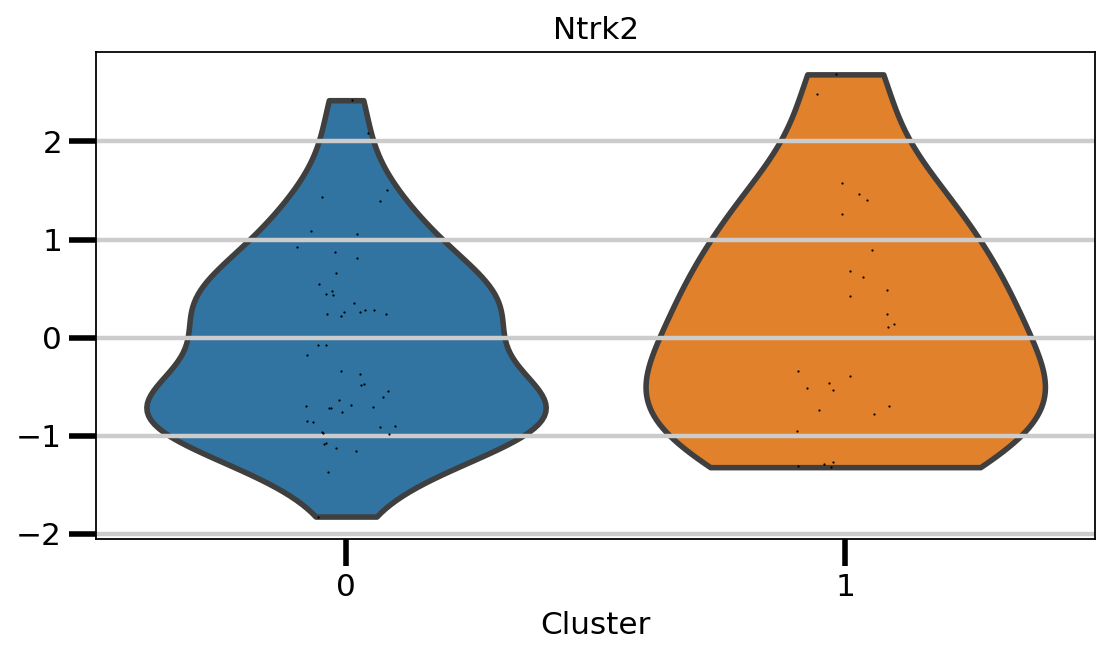

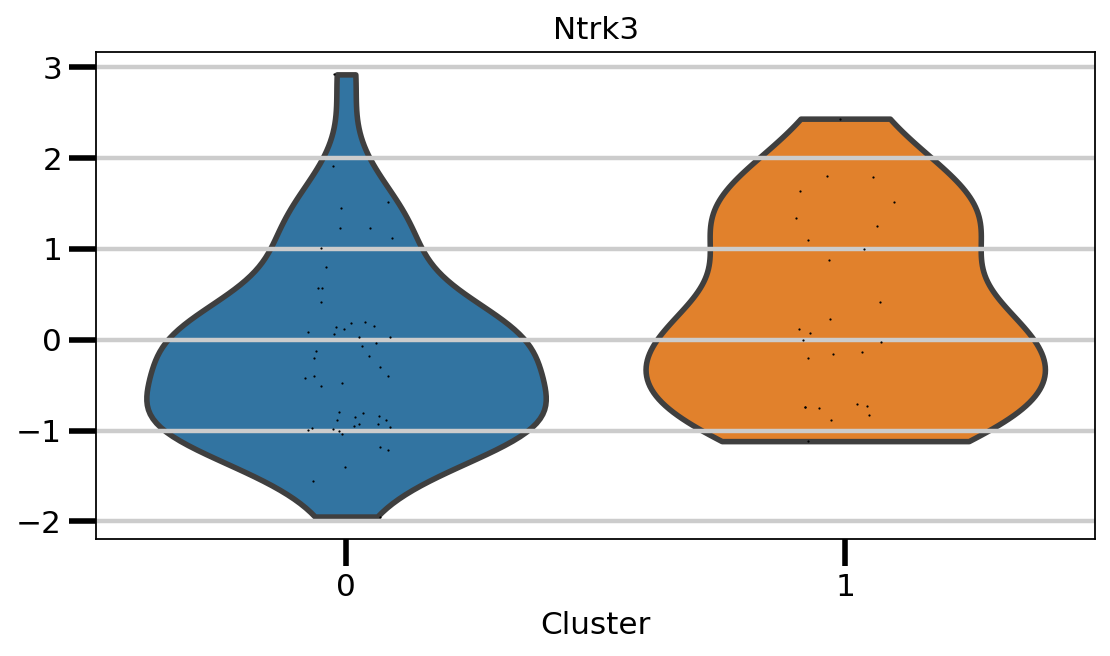

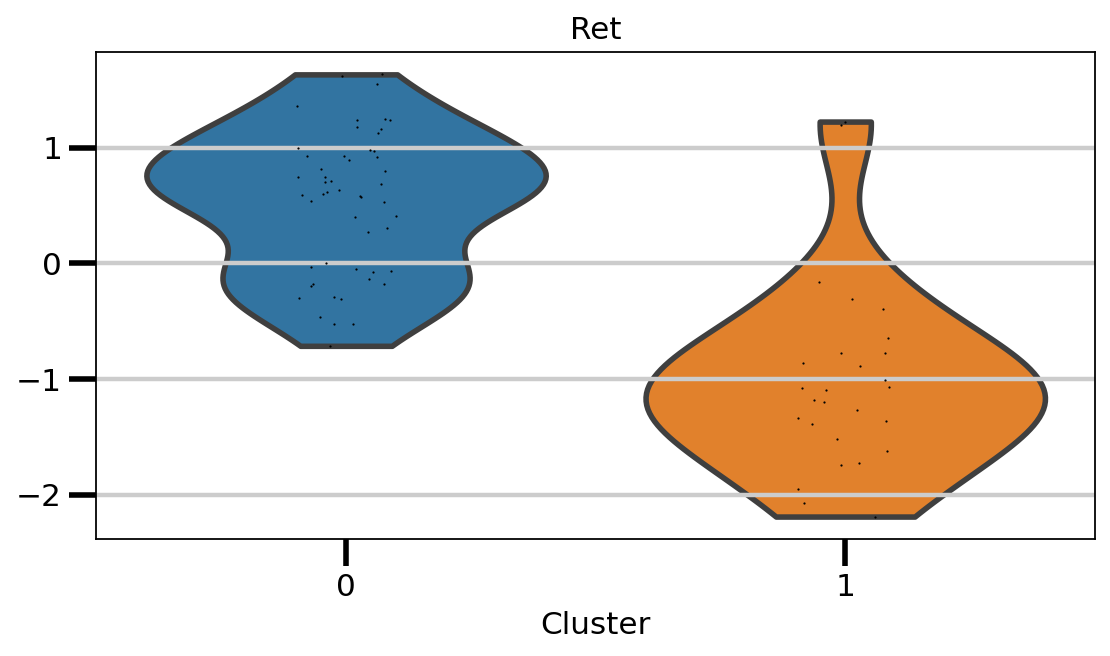

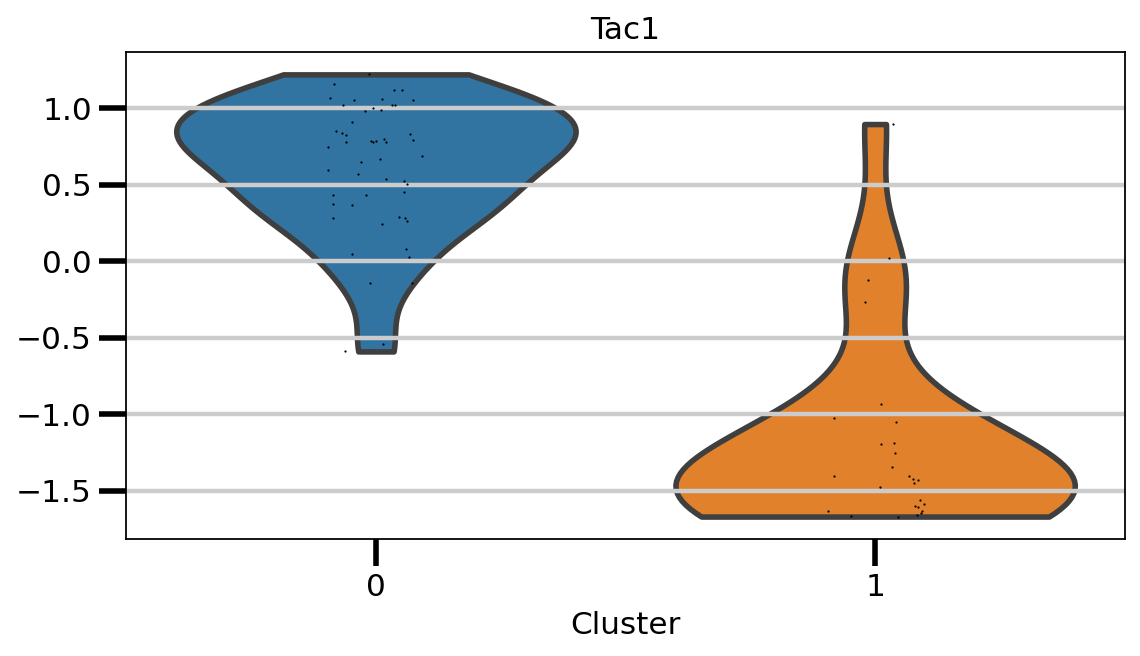

In [59]:
# svg plot for marcin
SELECTED_LOUVAIN = 'louvain_r0.5'
for gene in genes4df:
    try:
        fig, ax = plt.subplots(figsize=(8, 4))
        ax.set_title(gene)
        sc.pl.violin(adata_tomato, gene, use_raw=False, groupby=SELECTED_LOUVAIN,xlabel='Cluster', ylabel='',ax = ax)
        # sc.pl.violin(adata_tomato, gene, use_raw=False, groupby=SELECTED_LOUVAIN,xlabel='Cluster', ylabel='',save='violin_'+gene+'_'+SELECTED_LOUVAIN+'.svg')
    except:
        print(f"missing: {gene}")

In [61]:
# export dfs for Marcin
path2save_folder = os.path.join(input_path,"Tomato_only_genes_kallisto")
for g in genes4df:
    index_of_gene = np.where(adata_tomato.var['gene_name']==g)[0][0]
    # create dataframe
    gene_df = pd.DataFrame({"values": adata_tomato.X[:,index_of_gene],
                            "clusters": adata_tomato.obs[SELECTED_LOUVAIN]})
    path2dataframes = os.path.join(path2save_folder , "tomato_data_only_"+g+"_"+SELECTED_LOUVAIN+"_"+str(today)+'.csv')
    gene_df.to_csv(path2dataframes, index=False)